In [1]:
import sys
sys.path.append('..')
from importlib import reload
from utils import txt_to_nparray, visualization, check, transform_id
reload(txt_to_nparray)
reload(visualization)
reload(check)
import numpy as np
import matplotlib.pyplot as plt

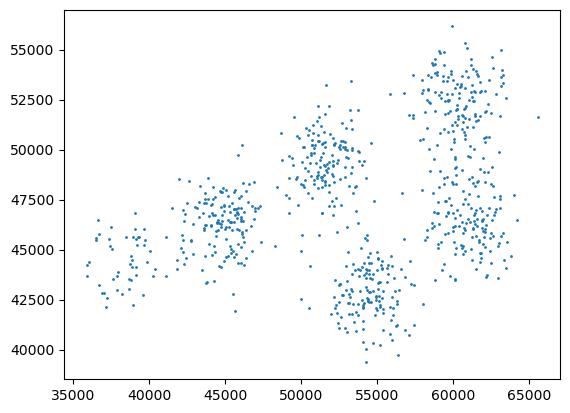

In [2]:
dataset = txt_to_nparray.read_txt_file('../dataset/A-sets/a1.txt', with_data_id=True)
dataset = dataset[0:800]
plt.scatter(dataset[:,1], dataset[:,2], s=1)

In [3]:
from serial import dbscan
reload(dbscan)
MIN_PTS = 4
EPSILON = 900

## Pesudo-parallel

In [4]:
x_min, x_max = np.min(dataset[:,1]), np.max(dataset[:,1])
y_min, y_max = np.min(dataset[:,2]), np.max(dataset[:,2])
print(x_min, x_max, y_min, y_max, '\nlength:', x_max-x_min, y_max-y_min)

X_UNIT, Y_UNIT = 5000, 5000
SPAN_MARGIN = EPSILON/2 + 1 # +1 to avoid the case that the point is on the boundary

# generate the splitting area
x_grid = np.arange(x_min, x_max + X_UNIT, X_UNIT)
y_grid = np.arange(y_min, y_max + Y_UNIT, Y_UNIT)

print('x_grid:', x_grid)
print('y_grid:', y_grid)

35876 65535 39356 56156 
length: 29659 16800
x_grid: [35876 40876 45876 50876 55876 60876 65876]
y_grid: [39356 44356 49356 54356 59356]


In [5]:
area_list = []
for x_idx, x_start in enumerate(x_grid[:-1]):
    for y_idx, y_start in enumerate(y_grid[:-1]):
        x_start_adjusted = x_start - SPAN_MARGIN
        y_start_adjusted = y_start - SPAN_MARGIN
        x_end_adjusted = x_grid[x_idx+1] + SPAN_MARGIN
        y_end_adjusted = y_grid[y_idx+1] + SPAN_MARGIN
        area_list.append([x_start_adjusted, x_end_adjusted, y_start_adjusted, y_end_adjusted])
assert len(area_list) == (len(x_grid)-1)*(len(y_grid)-1)

In [8]:
# Input: dataset (id:0-N, x, y) 
# Output: area_list
#   or : [(data_id=0, split_id),
#         (data_id=1, split_id),
# ]

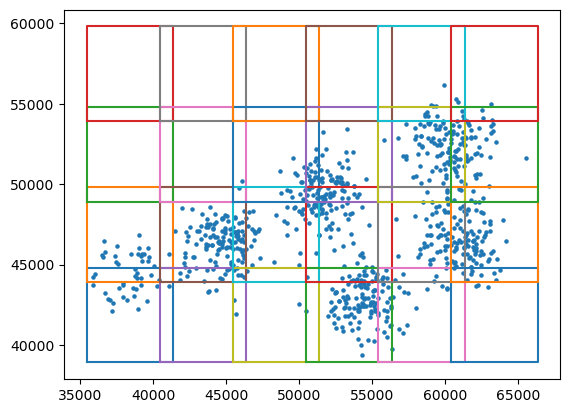

In [41]:
visualization.visualize_dataset_with_split(dataset[:,1:], area_list)

In [42]:
# local dbscan
reload(transform_id)
S = len(area_list)
print('total number of splits:', S)
data_id_cluster_id_list = []
for split_id, (x_start, x_end, y_start, y_end) in enumerate(area_list):
    # print('split_id:', split_id)
    dataset_in_split = dataset[(dataset[:,1] >= x_start) & (dataset[:,1] <= x_end) & 
                               (dataset[:,2] >= y_start) & (dataset[:,2] <= y_end)]
    pred_labels = dbscan.dbscan(dataset_in_split[:, 1:], EPSILON, MIN_PTS)
    transformed_pred_labels = list(map(lambda x: transform_id.transform(i=split_id, S=S, k=x), pred_labels))
    data_id_cluster_id = np.column_stack((dataset_in_split[:,0], transformed_pred_labels))
    data_id_cluster_id_list.append(data_id_cluster_id)

data_id_cluster_id_list_array = np.concatenate(data_id_cluster_id_list).astype(int)

total number of splits: 24


In [43]:
def reduce_by_key(data_id_cluster_id_list_array, noise_label=-2):
    '''
    data_id_cluster_id_list: np.array, with two columns: data_id and cluster_id
    '''
    
    all_data_id = data_id_cluster_id_list_array[:,0]
    assert len(set(all_data_id)) == 800
    
    final_cluster_id = np.zeros(len(set(all_data_id))).astype(int) - 1
    
    dict_reduced_result = {}
    for data_id in set(all_data_id):
        cluster_ids = set(data_id_cluster_id_list_array[data_id_cluster_id_list_array[:,0] == data_id, 1])
        dict_reduced_result[data_id] = sorted(list(cluster_ids))
        
        final_cluster_id[data_id] = dict_reduced_result[data_id][-1]
    
    # remove those pairs with len(value) == 1
    dict_reduced_result = {k:v for k, v in dict_reduced_result.items() if len(v) > 1}

    for data_id, cluster_ids in dict_reduced_result.items():
        if noise_label in cluster_ids:
            cluster_ids.remove(noise_label)
            assert noise_label not in cluster_ids
            cluster_ids = sorted(cluster_ids)            
    
    set_list = [set(x) for x in dict_reduced_result.values()]
    def merge_intersecting_sets(set_list):
        merged_sets = []
        while set_list:
            current_set = set_list.pop(0)  # 从list中取出一个集合
            merged = None
            # 查找第一个与current_set有交集的集合
            for i, merged_set in enumerate(merged_sets):
                if merged_set & current_set:
                    merged_set.update(current_set)
                    merged = i
                    break
            if merged is None:  # 没有发现交集
                merged_sets.append(current_set)
            else:  # 发现交集，再次合并可能的交集
                new_merged_set = merged_sets.pop(merged)
                set_list.append(new_merged_set)  # 将更新后的集合重新加入检查
        return merged_sets

    merged_sets = merge_intersecting_sets(set_list)
    
    cluster_id_map = dict()
    for one_set in merged_sets:
        list_set = sorted(list(one_set))
        cluster_id_map.update({src: list_set[0] for src in list_set[1:]})
        
    def select_min_cluster_id(origin_cluster_id):
        if cluster_id_map.get(origin_cluster_id) is None:
            return origin_cluster_id
        else:
            return cluster_id_map.get(origin_cluster_id)

    for data_id in range(final_cluster_id.shape[0]):
        final_cluster_id[data_id] = select_min_cluster_id(final_cluster_id[data_id])
    
    return final_cluster_id

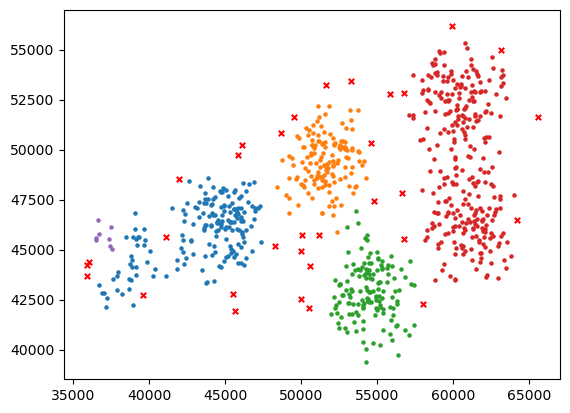

In [48]:
final_cluster_id = reduce_by_key(data_id_cluster_id_list_array)
visualization.visualize_dataset_with_label(dataset[:,1:], final_cluster_id)

{1, 2, 3, 4, 5, -2}


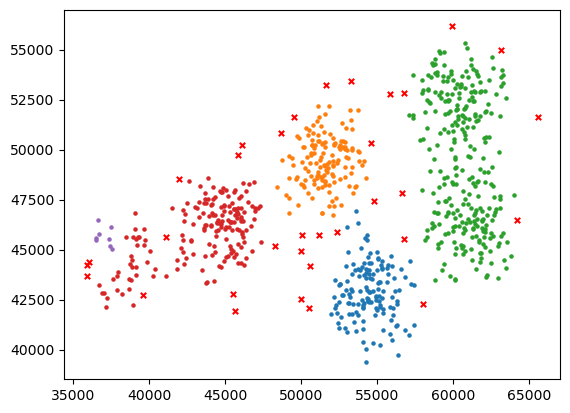

In [46]:
pred_labels = dbscan.dbscan(dataset, 900, MIN_PTS)
check.check_cluster_number(pred_labels, MIN_PTS)
reload(visualization)
print(set(pred_labels))
visualization.visualize_dataset_with_label(dataset[:, 1:], pred_labels)